## This notebook will walk you through the code used to generate figure 1 

* Dependencies
    * For Python reqs.see requirements.txt
    * For R reqs, Version 4.0.2, and [ArchR](https://github.com/GreenleafLab/ArchR) installed.





In [4]:
%load_ext rpy2.ipython
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import gzip
import os
from pybedtools import BedTool
import glob
import scanpy as sc
from scipy import stats, sparse
import scipy.io
from sklearn.preprocessing import Binarizer
from matplotlib.backends.backend_pdf import PdfPages
import umap 
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer

# Colormap from archR 
horizontalExtra = ["#000436", "#021EA9", "#1632FB", "#6E34FC", "#C732D5", "#FD619D","#FF9965","#FFD32B","#FFFC5A"]
sns.set_palette(horizontalExtra)
my_cmap = mpl.colors.ListedColormap(sns.color_palette(horizontalExtra).as_hex())
horizontalExtra_5 = ["#000436", "#1632FB", "#C732D5", "#FF9965", "#FFFC5A"]

mpl.rc('font', family='serif')
mpl.rc('axes', labelsize=16)
mpl.rc('axes', titlesize=16)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### Run ArchR Analysis

Below is a function that takes you through the standard archR analysis pipeline. See reference [here](https://www.archrproject.com/articles/Articles/tutorial.html). We'll pipe out the colData from archR object, save it as a csv and plot the resulting data in matplotlib.

In [2]:
# make temp file to store all intermediate output from ArchR
try:
    os.mkdir("temp")
except FileExistsError:
    print("File Already Exists")

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,


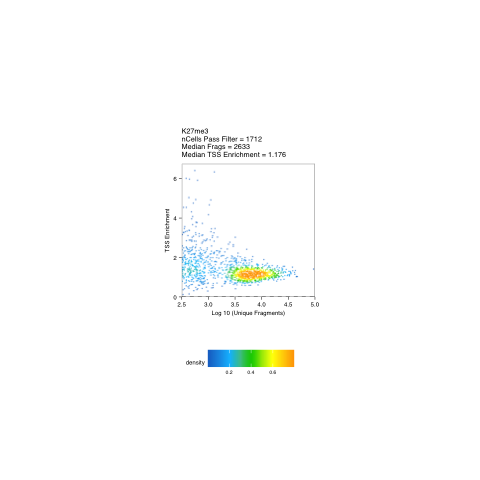

In [3]:
%%R 

# load archR library and genome
library(ArchR)
set.seed(1)
addArchRGenome("hg38")

archR_pipline <- function(input_file, sample_name, out_file){
    "
    Standard archR pipeline. Output is a saved CSV with colMETA data that includes reduced UMAP coordinates.
    reference - https://www.archrproject.com/articles/Articles/tutorial.html

    Args:
        input_file (str): path to fragment file
        sample_name (str): sample name
        out_file (str): name to save csv file with metadata to
    "

    
    inputFiles <- structure(c(input_file), .Names = c(sample_name))

    tilematparams <- list(5000)
    names(tilematparams) <- "tileSize"

    ArrowFiles <- createArrowFiles(
      inputFiles = inputFiles,
      sampleNames = names(inputFiles),
      filterTSS = 0, #Dont set this too high because you can always increase later
      filterFrags = 100, 
      addTileMat = TRUE,
      addGeneScoreMat = TRUE,
      minFrags = 100,
      TileMatParams = tilematparams
    )

    proj <- ArchRProject(
      ArrowFiles = ArrowFiles
    )

    proj <- addIterativeLSI(ArchRProj = proj, useMatrix = "TileMatrix", name = "IterativeLSI", iterations = 1,
                            force=TRUE, dimsToUse = 1:50)
    proj <- addUMAP(ArchRProj = proj, reducedDims = "IterativeLSI", force=TRUE)
    proj$`IterativeLSI#UMAP_Dimension_1` <- proj@embeddings$UMAP$df$`IterativeLSI#UMAP_Dimension_1`
    proj$`IterativeLSI#UMAP_Dimension_2` <- proj@embeddings$UMAP$df$`IterativeLSI#UMAP_Dimension_2`
    write.csv(getCellColData(proj), out_file, quote=FALSE)
}

# Path to fragment file
path_k4me2 = 'sc_fragfiles/K4me2_stdcells.fragments.tsv.gz'
path_k27me3 = 'sc_fragfiles/K27me3_stdcells.fragments.tsv.gz'

# Running standard archR pipeline
archR_pipline(path_k4me2, 'K4me2', 'temp/k4me2_stdcells_coldata.csv')
archR_pipline(path_k27me3, 'K27me3', 'temp/k27me3_stdcells_coldata.csv')

In [5]:
# load in CSV generated above with cell metadata and add a celltype/replicate column
def preprocess_df(coldata_csv):
    """
    Takes in cell metadata and parses full sample name for individual cell name/replicate
    
    Args: 
        coldata_csv (str): path to saved csv file
        
    Returns:
        pd.DataFrame
    """
    
    df = pd.read_csv(coldata_csv, delimiter=',')
    ct = []
    ct_norep = []
    for i in df.iloc[:,0]:
        i = i.upper()
        i = i.split('#')[-1].split('_')
        ct.append(' '.join(i[1:3]))
        ct_norep.append(i[1])
    dftypes = pd.DataFrame([ct, ct_norep], index=['ct', 'ct_norep']).T
    return pd.concat([df, dftypes], axis=1)


In [49]:
# Load pdf object
pdf_obj = PdfPages('Fig1_tmp.pdf')

# calls the function above method and loads in celldata CSV
path_k27me3 = 'temp/k27me3_stdcells_coldata.csv'
data_k27m3 = preprocess_df(path_k27me3)

path_k4me2 = 'temp/k4me2_stdcells_coldata.csv'
data_k4m2 = preprocess_df(path_k4me2)

### Plot Fig 1b. 

TODO: Project or Coembed published scATACseq data for similar celltypes

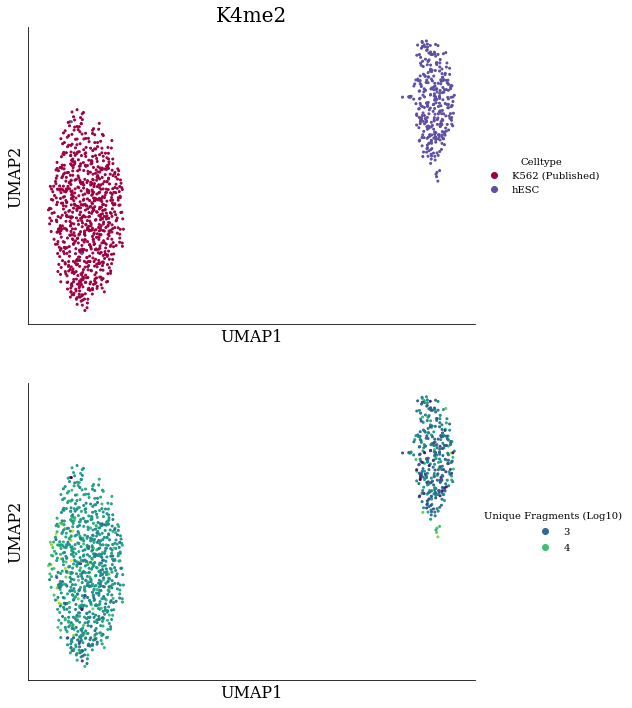

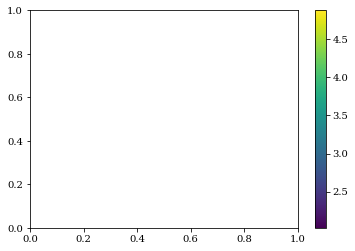

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(8,12))
cmap_ct = {'K562':0, 'H1':1}
labels_k4 = np.array([cmap_ct[i] for i in data_k4m2['ct_norep']])

# Scatter Plot of Data
scatter1 = ax[0].scatter(data_k4m2['IterativeLSI.UMAP_Dimension_1'], 
         data_k4m2['IterativeLSI.UMAP_Dimension_2'],
         alpha=1, 
          c=labels_k4, 
              s=4,
            cmap='Spectral')
scatter2 = ax[1].scatter(data_k4m2['IterativeLSI.UMAP_Dimension_1'], 
         data_k4m2['IterativeLSI.UMAP_Dimension_2'],
         alpha=1, 
          c=np.log10(data_k4m2['nFrags']), 
              s=4)

ax[0].set_xlabel('UMAP1', fontsize=16)
ax[0].set_ylabel('UMAP2', fontsize=16)
ax[1].set_xlabel('UMAP1', fontsize=16)
ax[1].set_ylabel('UMAP2', fontsize=16)

# aesthetics
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
plt.grid(False)
plt.setp(ax, xticks=[], yticks=[])

# legend
ax[0].legend(handles=scatter1.legend_elements()[0], loc='center left', bbox_to_anchor=(1, 0.5),
                    frameon=False, title=("Celltype"), labels=['K562 (Published)', 'hESC'])

ax[1].legend(*scatter2.legend_elements(num=3),
                     title=("Unique Fragments (Log10)"),
                   loc='center left', bbox_to_anchor=(1, 0.5),
                   frameon=False)

ax[0].set_title("K4me2", fontsize=20)
plt.savefig("Fig1_tmpa.pdf", bbox_inches='tight', transparent=True)

plt.figure()
plt.colorbar(scatter2)
plt.savefig("Fig1_tmpb.pdf")


### Project scATAC onto K4me2 space

In [7]:
# load data
mtx = scipy.io.mmread("misc_data/K4me2_scATAC.mtx")
colData = pd.read_csv("misc_data/K4me2_scATAC.csv", sep=',')

# rename celltypes
ct = []
for i in colData['Unnamed: 0']:
    if "SRR" in i:
        ct.append(i.split("#")[0])
    else:
        ct.append("_".join(i.split("#")[1].split("_")[0:2]))
colData['ct'] = ct
nCells = colData.shape[0]

#Transform Data
csr = sparse.csr_matrix(mtx.T)
k4m2_idx = colData['ct'].str.contains("K4me2")
csr_k4me2 = csr[list(colData[k4m2_idx].index), :]
csr_atac = csr[list(colData[~k4m2_idx].index), :]

tfidf_k4 = TfidfTransformer().fit_transform(X=csr_k4me2)
tfidf_atac = TfidfTransformer().fit_transform(X=csr_atac)

red_k4 = TruncatedSVD(n_components=50, random_state=42).fit_transform(tfidf_k4)
red_atac = TruncatedSVD(n_components=50, random_state=42).fit_transform(tfidf_atac)
mapper = umap.UMAP().fit(red_k4)
atac = mapper.transform(red_atac)

embed_projs = np.vstack([mapper.embedding_, atac])
colData['umap_proj1'] = embed_projs[:,0]
colData['umap_proj2'] = embed_projs[:,1]

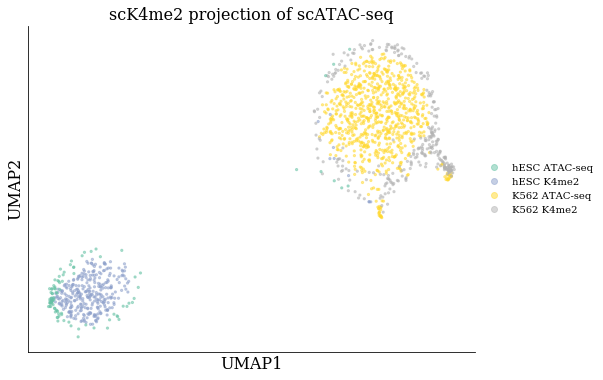

In [8]:
plt.figure(figsize=(8,6))
ax = plt.axes()
cmap_ct = {'H1':0, 'K4me2_H1': 1, 'K4me2_K562':2, 'K562':3}
labels_k4 = np.array([cmap_ct[i] for i in colData['ct']])


scatter1 = plt.scatter(colData['umap_proj1'], 
         colData['umap_proj2'],
         alpha=.5, 
          c=labels_k4, 
              s=5,
          cmap="Set2")
plt.legend(handles=scatter1.legend_elements()[0], loc='center left', bbox_to_anchor=(1, 0.5),
                    frameon=False, labels=['hESC ATAC-seq', 'hESC K4me2', 'K562 ATAC-seq', 'K562 K4me2'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(False)
plt.setp(ax, xticks=[], yticks=[])
ax.set_title('scK4me2 projection of scATAC-seq')
ax.set_ylabel('UMAP2')
ax.set_xlabel('UMAP1')

pdf_obj.savefig(bbox_inches='tight', transparent=True)

### Plot Fig 1c. 

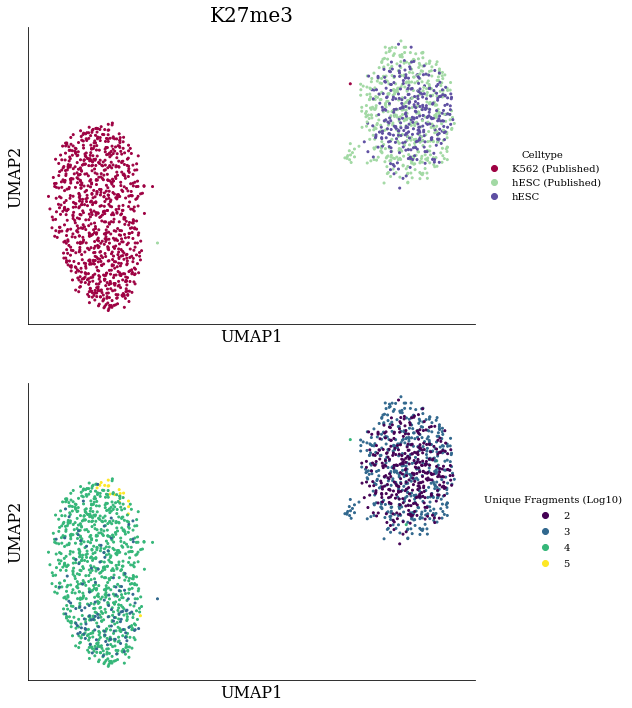

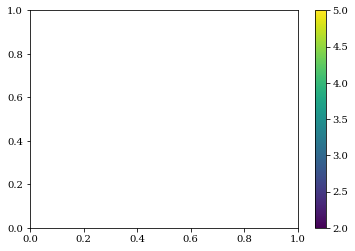

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(8,12))
cmap_ct = {'K562 R1':0, 'H1 R1':5, 'H1 R2':7}
labels_k27 = np.array([cmap_ct[i] for i in data_k27m3['ct']])

# Scatter Plot of Data
scatter1 = ax[0].scatter(data_k27m3['IterativeLSI.UMAP_Dimension_1'], 
         data_k27m3['IterativeLSI.UMAP_Dimension_2'],
         alpha=1, 
          c=labels_k27, 
              s=4,
          cmap="Spectral")

scatter2 = ax[1].scatter(data_k27m3['IterativeLSI.UMAP_Dimension_1'], 
         data_k27m3['IterativeLSI.UMAP_Dimension_2'],
         alpha=1, 
          c=np.round(np.log10(data_k27m3['nFrags'])), 
              s=4)

ax[0].set_xlabel('UMAP1', fontsize=16)
ax[0].set_ylabel('UMAP2', fontsize=16)
ax[1].set_xlabel('UMAP1', fontsize=16)
ax[1].set_ylabel('UMAP2', fontsize=16)
# aesthetics
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
plt.grid(False)
plt.setp(ax, xticks=[], yticks=[])

ax[0].legend(handles=scatter1.legend_elements()[0], loc='center left', bbox_to_anchor=(1, 0.5),
                    frameon=False, title=("Celltype"), labels=['K562 (Published)', 'hESC (Published)', 'hESC'])
ax[1].legend(*scatter2.legend_elements(num=3),
                     title=("Unique Fragments (Log10)"),
                   loc='center left', bbox_to_anchor=(1, 0.5),
                   frameon=False)
ax[0].set_title("K27me3", fontsize=20)

# pdf_obj.savefig(bbox_inches='tight', transparent=True)

plt.savefig("Fig1_tmpa.pdf", bbox_inches='tight', transparent=True)

plt.figure()
plt.colorbar(scatter2)
plt.savefig("Fig1_tmpb.pdf")

In [48]:
pdf_obj.close()

### Fig 1c Supp

Library Size is quite different between H1/K562 cells. Downsample k562 single cells and see if data partitions based off of cell identity.


In [10]:
def sc_subsample(path_frag, nFrags, outname):
    '''
    Reads in a fragment file and subsamples all single cell to a value.
    If a single cell doesn't have that many reads, all of them get written out. 
    Resultant fragfile will be automatically bgzipped.
    
    Args:
        nFrags (int) : number of frags to subsample 
        path_frag (str): path to fragment file
        outname (str): file to write downsample fragments to
    '''
    fin = gzip.open(path_frag, 'rb')
    dict_sc = {}
    for rd in fin:
        barc = rd.decode().strip().split('\t')[3]
        try: 
            dict_sc[barc].append(rd.decode())
        except KeyError:
            dict_sc[barc] = [rd.decode()]

    fout = open(outname, 'w')
    for barcode in dict_sc:
        sc = dict_sc[barcode]
        if len(sc) > nFrags:
            idxrand = np.random.choice(range(len(sc)), nFrags, replace=False)
            sc = list(map(sc.__getitem__, idxrand))
        for frag in sc:
            fout.write(frag)
    
    os.system("sort -k1,1 -k2,2n " + outname + " > foo")
    os.system("mv foo " + outname)
    os.system("bgzip " + outname)
            

In [11]:
# get median number of unique frags for H1 cells
medfrags_h1 = np.median(data_k27m3[data_k27m3['ct_norep'] == 'H1']['nFrags'])
medfrags_h1 = int(medfrags_h1)

# downsample Fragments
path_k27me3 = 'sc_fragfiles/K27me3_stdcells.fragments.tsv.gz'
outpath_k27me3 = 'temp/K27me3_stdcells.fragments_downsample.tsv'
sc_subsample(path_k27me3, medfrags_h1, outpath_k27me3)

R[write to console]: Using GeneAnnotation set by addArchRGenome(Hg38)!

R[write to console]: Using GeneAnnotation set by addArchRGenome(Hg38)!

R[write to console]: ArchR logging to : ArchRLogs/ArchR-createArrows-1130a2eb620b4-Date-2020-08-20_Time-10-59-03.log
If there is an issue, please report to github with logFile!

R[write to console]: 2020-08-20 10:59:04 : Batch Execution w/ safelapply!, 0 mins elapsed.

R[write to console]: Attempting to index temp/K27me3_stdcells.fragments_downsample.tsv.gz as tabix..

R[write to console]: 2020-08-20 10:59:04 : (K27me3_ds : 1 of 1) Reading In Fragments from inputFiles (readMethod = tabix), 0.008 mins elapsed.

R[write to console]: 2020-08-20 10:59:04 : (K27me3_ds : 1 of 1) Tabix Bed To Temporary File, 0.008 mins elapsed.

R[write to console]: 2020-08-20 11:01:22 : (K27me3_ds : 1 of 1) Successful creation of Temporary File, 2.307 mins elapsed.

R[write to console]: 2020-08-20 11:01:22 : (K27me3_ds : 1 of 1) Creating ArrowFile From Temporary File

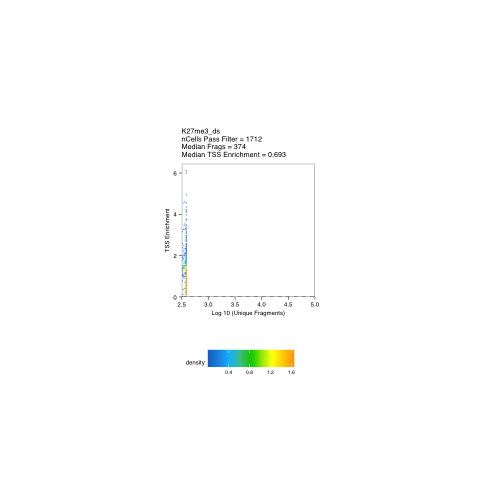

In [12]:
%%R
# Run archR pipeline
path_k27me3_ds = "temp/K27me3_stdcells.fragments_downsample.tsv.gz"
archR_pipline(path_k27me3_ds, 'K27me3_ds', 'temp/k27me3_stdcells_ds_coldata.csv')

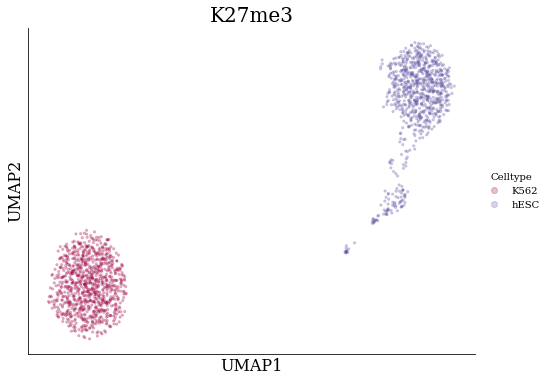

In [13]:
# TODO: Fix Colors

path_ds = 'temp/k27me3_stdcells_ds_coldata.csv'
ds_k27me3 = preprocess_df(path_ds)

fig, ax = plt.subplots(figsize=(8,6))
cmap_ct = {'K562':0, 'H1':1}
labels_k27 = np.array([cmap_ct[i] for i in ds_k27me3['ct_norep']])

# Scatter Plot of Data
scatter = ax.scatter(ds_k27me3['IterativeLSI.UMAP_Dimension_1'], 
         ds_k27me3['IterativeLSI.UMAP_Dimension_2'],
         alpha=0.25,  
              s=5,
              c=labels_k27,
          cmap="Spectral")

ax.set_xlabel('UMAP1', fontsize=16)
ax.set_ylabel('UMAP2', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(False)
plt.setp(ax, xticks=[], yticks=[])
plt.title("K27me3", fontsize=20)
ax.legend(handles=scatter.legend_elements()[0], loc='center left', bbox_to_anchor=(1, 0.5),
                    frameon=False, title=("Celltype"), labels=['K562', 'hESC'])

pdf_obj.savefig(bbox_inches='tight', transparent=True)

### Compare single cell Profiles to Bulk Profiles

In [14]:
def filter_fragfile(colData, fragpath, fout):
    '''
    Filter out cells from the fragment file that didn't make the ArchR cut
    
    Args:
        colData (pd.DataFrame): 
        fragpath (str): path to fragment file
        fout (str): out file name
    '''
    barcodes = {i.split('#')[1]:'' for i in colData['Unnamed: 0']}
    fin = gzip.open(fragpath, 'rb')
    fout = open(fout, 'w')
    for read in fin:
        # this assume barcode is on the 4th column of the frag file
        barc = read.decode().strip().split("\t")[3]
        if barc in barcodes:
            fout.write(read.decode())
    
    

def peak_enrichment(df, fragfile, peakfile):
    '''
    Takes in a dataframe of data from archR (coldata) project and superimposes read enrichment at specific loci 
    over the umap coords.
    Args:
        df (pd.DataFrame) : 
        fragfile (str): path to fragment file
        peakfile (str): path to peak file
        
    Returns:    
    
    '''
    peak_name = peakfile.split("/")[-1].split('.')[0] + "_FRIPS"
    
    frag = BedTool(fragfile) 
    peaks = BedTool(peakfile)
    inter = frag.intersect(peaks)
    
    counter = {}
    for interval in inter:
        rd = interval.fields
        try:
            counter[rd[3]] +=1
        except KeyError: 
            counter[rd[3]] = 1
    
    rdcounts = []
    for i in df['Unnamed: 0']:
        name = i.split('#')[-1]
        try:
            nrds = counter[name] 
            rdcounts.append(nrds)
        except KeyError:
            rdcounts.append(0)
    
    rdcounts = pd.DataFrame(rdcounts, columns=[peak_name])
    df = pd.concat([df, rdcounts], axis=1)
     
    return df


In [15]:
# Remove bad cells from fragment file
filter_fragfile(data_k27m3, "sc_fragfiles/K27me3_stdcells.fragments.tsv.gz",
                "temp/K27me3_stdcells_filter.fragments.tsv.gz")
filter_fragfile(data_k4m2, "sc_fragfiles/K4me2_stdcells.fragments.tsv.gz", 
                "temp/K4me2_stdcells_filter.fragments.tsv.gz")

fragpaths = ["temp/K27me3_stdcells_filter.fragments.tsv.gz",
             "temp/K4me2_stdcells_filter.fragments.tsv.gz"]
peakpaths = ["peak_files/H1_atac_repsmerge_peaks.narrowPeak",
             "peak_files/K27me3_H1_0912.relaxed.bed",
             "peak_files/K27me3_K5_0912.relaxed.bed", 
             "peak_files/K4me2_H1_0912_peaks.narrowPeak",
             "peak_files/K4me2_K5_0912_peaks.narrowPeak",
             "peak_files/K562_atac_repsmerge_peaks.narrowPeak"]

# Get number of reads in peaks
for peaks in peakpaths:
    if "K4me2" in peaks:
        data_k4m2 = peak_enrichment(data_k4m2, fragpaths[1], peaks)
    elif "K27me3" in peaks:
        data_k27m3 = peak_enrichment(data_k27m3, fragpaths[0], peaks)
    else:
        data_k27m3 = peak_enrichment(data_k27m3, fragpaths[0], peaks)
        data_k4m2 = peak_enrichment(data_k4m2, fragpaths[1], peaks)

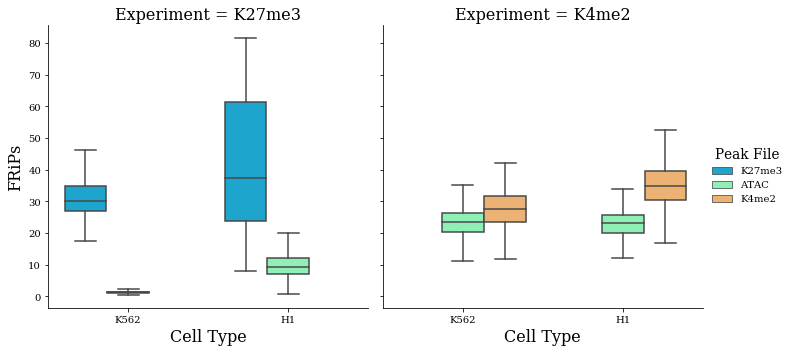

In [16]:
# Melt dataframe together for boxplot
foo1 = ['K27me3' for i in range(data_k27m3.shape[0])]
foo2 = ['ATAC' for i in range(data_k27m3.shape[0])]
foo3 = ['K4me2' for i in range(data_k4m2.shape[0])]
foo4 = ['ATAC' for i in range(data_k4m2.shape[0])]

# Codes kind of crappy, but iteratres through DF and depending on celltype calculates frips for each peakset
tmp_frips = []
for k, i in data_k27m3.iterrows():
    if i['ct_norep'] == "K562":
        tmp_frips.append(i['K27me3_K5_0912_FRIPS']/i['nFrags'] * 100)
    else:
        tmp_frips.append(i['K27me3_H1_0912_FRIPS']/i['nFrags'] * 100)

for k, i in data_k27m3.iterrows():
    if i['ct_norep'] == "K562":
        tmp_frips.append(i['K562_atac_repsmerge_peaks_FRIPS']/i['nFrags'] * 100)
    else:
        tmp_frips.append(i['H1_atac_repsmerge_peaks_FRIPS']/i['nFrags'] * 100)
        
for k, i in data_k4m2.iterrows():
    if i['ct_norep'] == "K562":
        tmp_frips.append(i['K4me2_K5_0912_peaks_FRIPS']/i['nFrags'] * 100)
    else:
        tmp_frips.append(i['K4me2_H1_0912_peaks_FRIPS']/i['nFrags'] * 100)

for k, i in data_k4m2.iterrows():
    if i['ct_norep'] == "K562":
        tmp_frips.append(i['K562_atac_repsmerge_peaks_FRIPS']/i['nFrags'] * 100)
    else:
        tmp_frips.append(i['H1_atac_repsmerge_peaks_FRIPS']/i['nFrags'] * 100)

        
        
        
colA = list(data_k27m3['ct_norep']) *2  + list(data_k4m2['ct_norep']) *2
colB = foo1 + foo2 + foo3 + foo4
# get FrIps depending on celltype
colC = tmp_frips
colD = ["K27me3" for i in range(len(foo1 + foo2))] + ["K4me2" for i in range(len(foo3 + foo4))]

df_tmp = pd.DataFrame([colA, colB, colC, colD], index=['Cell Type', 'Peak File', 'FRiPs', 'Experiment']).T
sns.catplot(x="Cell Type", y="FRiPs", hue="Peak File", 
               data=df_tmp, palette='rainbow', col="Experiment", kind='box', showfliers=False)

pdf_obj.savefig(bbox_inches='tight', transparent=True)

### Correlation get coverage across single cell vs Bulk Data

In [17]:
def getCoverage(bed, peakfile):
    '''
    Takes in bedfile and peakfile and computes number of reads in the bed file that overlap with a
    peak file. 
    
    Args:
        fragfile (str): path to fragment file
        peakfile (str): path to peak file
        
    Returns:    
        norm_counts (csr_matrix): 
        
    '''
    
    frag = BedTool(bed) 
    peaks = BedTool(peakfile)
    inter = peaks.coverage(frag, counts=True)
    norm_counts = np.zeros(peaks.count())
    for k, interval in enumerate(inter):
        rd = interval.fields
        norm_counts[k] = rd[-1]

    norm_counts /= frag.count()
    norm_counts *= 1000000
    norm_counts = np.log(norm_counts + 1)
    return sparse.csr_matrix(norm_counts)

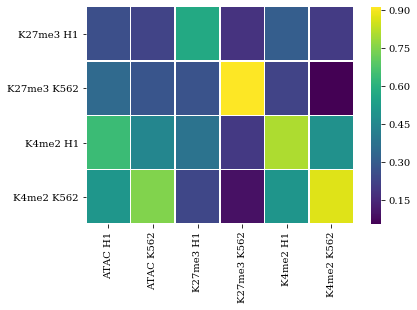

In [19]:
beds = sorted(glob.glob("bulk_fragfiles/*0912.bed.gz") + 
              glob.glob("temp/*filter*tsv.??") + 
              glob.glob("bulk_fragfiles/*ATAC*.bed.gz"))
genomeWindow = "peak_files/hg38_5kbwindows.bed"
sprse_matrices = []
for i in beds:
    # BOTTLE NECK speed-wise of whole notebook
    sprse_matrices.append(getCoverage(i, genomeWindow))
    
scagg = sprse_matrices[6:]
scbulk = sprse_matrices[:6]
labels_sc = ['K27me3 H1', 'K27me3 K562', 'K4me2 H1', 'K4me2 K562']
labels_bulk = ['ATAC H1', 'ATAC K562', 'K27me3 H1', 'K27me3 K562', 'K4me2 H1', 'K4me2 K562']
corr = np.zeros([len(labels_sc), len(labels_bulk)])
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        x = np.array(scagg[i].todense()).squeeze()
        y = np.array(scbulk[j].todense()).squeeze()
        corr[i, j] = stats.pearsonr(x, y)[0]
        
corr = pd.DataFrame(corr, index=labels_sc, columns=labels_bulk)
sns.heatmap(corr, cmap='viridis', linewidths=.5)
pdf_obj.savefig(bbox_inches='tight', transparent=True)

### Start Analysis for H1-->DE Time Course

The chunk of R code below runs ArchR through the standard pipeline, retrieves the GSM, and cellmetadata.

R[write to console]: Using GeneAnnotation set by addArchRGenome(Hg38)!

R[write to console]: Using GeneAnnotation set by addArchRGenome(Hg38)!

R[write to console]: ArchR logging to : ArchRLogs/ArchR-createArrows-1130a7eca454a-Date-2020-08-20_Time-11-34-22.log
If there is an issue, please report to github with logFile!

R[write to console]: 2020-08-20 11:34:22 : Batch Execution w/ safelapply!, 0 mins elapsed.

R[write to console]: 2020-08-20 11:34:22 : (H1DE : 1 of 1) Arrow Exists! Marking as completed since force = FALSE!, 0 mins elapsed.

R[write to console]: ArchR logging successful to : ArchRLogs/ArchR-createArrows-1130a7eca454a-Date-2020-08-20_Time-11-34-22.log

R[write to console]: Using GeneAnnotation set by addArchRGenome(Hg38)!

R[write to console]: Using GeneAnnotation set by addArchRGenome(Hg38)!

R[write to console]: Validating Arrows...

R[write to console]: Getting SampleNames...

R[write to console]: 1 
R[write to console]: 

R[write to console]: Copying ArrowFiles to Ou

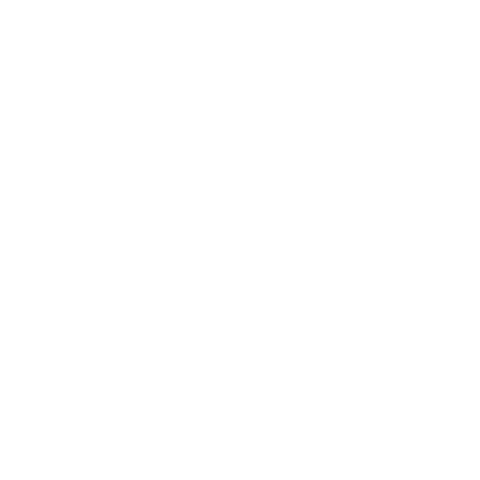

In [25]:
%%R
inputFiles <- structure(c("sc_fragfiles/K27me3_h1de.fragments.tsv.gz"), .Names = c('H1DE'))

tilematparams <- list(5000)
names(tilematparams) <- "tileSize"

ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles,
  sampleNames = names(inputFiles),
  filterTSS = 0, #Dont set this too high because you can always increase later
  filterFrags = 100, 
  addTileMat = TRUE,
  addGeneScoreMat = TRUE,
  minFrags = 100,
  TileMatParams = tilematparams
)

proj <- ArchRProject(
  ArrowFiles = ArrowFiles
)

proj <- addIterativeLSI(ArchRProj = proj, useMatrix = "TileMatrix", name = "IterativeLSI", iterations = 1,
                        force=TRUE, dimsToUse = 1:50)
proj <- addUMAP(ArchRProj = proj, reducedDims = "IterativeLSI", force=TRUE)
proj$`IterativeLSI#UMAP_Dimension_1` <- proj@embeddings$UMAP$df$`IterativeLSI#UMAP_Dimension_1`
proj$`IterativeLSI#UMAP_Dimension_2` <- proj@embeddings$UMAP$df$`IterativeLSI#UMAP_Dimension_2`

# write out coldata 
write.csv(getCellColData(proj), "temp/k27me3_h1de_coldata.csv", quote=FALSE)

# write out Gene Score Matrix
gsm <- getMatrixFromProject(proj)
writeMM(assay(gsm), "temp/gsm_H1DE.mtx")
write.csv(rowData(gsm), "temp/gsm_k27me3_h1de_geneAnnot.csv", quote=FALSE)

# Better methods to do this, but i'm a pleb @ R, basically adding celltype labels/timepoints to cellmetadata
ct = c()
for (name in proj$cellNames){
  ct <- append(ct, (strsplit(name, "_")[[1]][2]))
}
proj$ct <- ct

time = c()
for (name in ct){
  time <- append(time, strtoi(substring(name, 2, 2)))
}
proj$time <- time


trajectory <- c("H1DE", "H2DE", "H3DE", "H4DE", "H5DE")
proj <- addTrajectory(
    ArchRProj = proj, 
    name = "DE", 
    groupBy = "ct",
    trajectory = trajectory, 
    embedding = "UMAP", 
    force = TRUE
)
proj <- addImputeWeights(proj)
p <- plotTrajectory(proj, trajectory = "DE", name="time")
trajMM  <- getTrajectory(ArchRProj = proj, name = "DE", useMatrix = "GeneScoreMatrix", log2Norm = TRUE)


# TO DO LAPPLY vs. Calling all indivudally
p1 <- plotTrajectoryHeatmap(trajMM, pal = paletteContinuous(set = "horizonExtra"))
p11 <- plotTrajectory(proj, trajectory = "DE", colorBy = "GeneScoreMatrix", name = "SOX2", continuousSet = "horizonExtra")
p12 <- plotTrajectory(proj, trajectory = "DE", colorBy = "GeneScoreMatrix", name = "KLF4", continuousSet = "horizonExtra")
p13 <- plotTrajectory(proj, trajectory = "DE", colorBy = "GeneScoreMatrix", name = "FOXD3", continuousSet = "horizonExtra")
p21 <- plotTrajectory(proj, trajectory = "DE", colorBy = "GeneScoreMatrix", name = "TBXT", continuousSet = "horizonExtra")
p22 <- plotTrajectory(proj, trajectory = "DE", colorBy = "GeneScoreMatrix", name = "MSX2", continuousSet = "horizonExtra")
p23 <- plotTrajectory(proj, trajectory = "DE", colorBy = "GeneScoreMatrix", name = "EOMES", continuousSet = "horizonExtra")
p31 <- plotTrajectory(proj, trajectory = "DE", colorBy = "GeneScoreMatrix", name = "FOXA2", continuousSet = "horizonExtra")
p32 <- plotTrajectory(proj, trajectory = "DE", colorBy = "GeneScoreMatrix", name = "SOX17", continuousSet = "horizonExtra")
p33 <- plotTrajectory(proj, trajectory = "DE", colorBy = "GeneScoreMatrix", name = "PRDM1", continuousSet = "horizonExtra")


plotPDF(p11[[2]],p12[[2]],p13[[2]],
        p21[[2]],p22[[2]],p23[[2]],
        p31[[2]],p32[[2]],p33[[2]],
        p[[1]], p,
        name = "pseudotime.pdf", ArchRProj = proj, addDOC = FALSE, width = 5, height = 5)

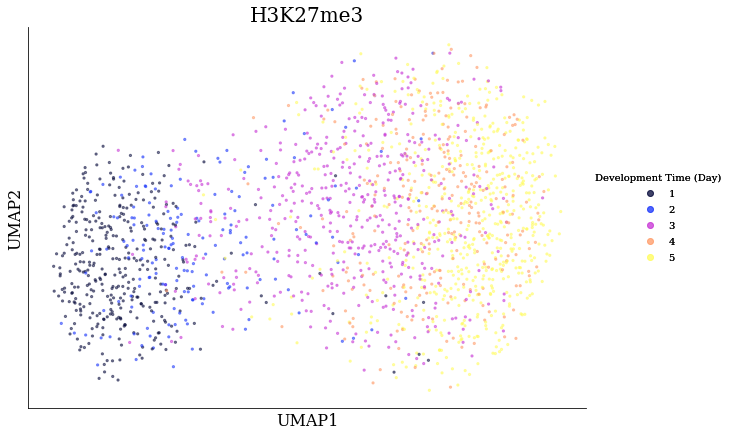

In [26]:
data_h1de = preprocess_df("temp/k27me3_h1de_coldata.csv")

# color mapping
cmap_ct = {i:k+1 for k, i in enumerate(sorted(list(set(data_h1de['ct_norep']))))}

labels = np.array([cmap_ct[i] for i in data_h1de['ct_norep']])

plt.figure(figsize=(10,7))
ax = plt.axes()
scatter = plt.scatter(data_h1de['IterativeLSI.UMAP_Dimension_1'], 
         data_h1de['IterativeLSI.UMAP_Dimension_2'],
         alpha=0.5, 
             s=5, 
             c=labels, 
            cmap=my_cmap)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('H3K27me3', fontsize=20)

plt.grid(False)
plt.setp(ax, xticks=[], yticks=[])
ax.set_ylabel('UMAP2')
ax.set_xlabel('UMAP1')


legend1 = ax.legend(*scatter.legend_elements(num=4),
                     title=("Development Time (Day" + ")"),
                   loc='center left', bbox_to_anchor=(1, 0.5),
                   frameon=False)
ax.add_artist(legend1)

pdf_obj.savefig(bbox_inches='tight', transparent=True)


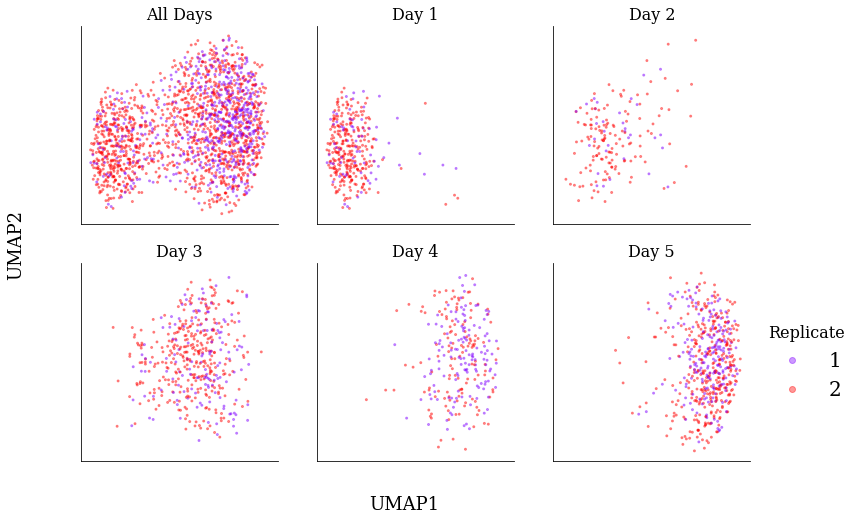

In [27]:
# color mapping
days = np.array(['', 'H1', 'H2', 'H3', 'H4', 'H5'])
days = days.reshape(2,3)

fig, ax = plt.subplots(2,3, figsize=(12,8), sharex=True, sharey=True)
for i in range(days.shape[0]):
    for j in range(days.shape[1]):
        day = days[i, j]
        day_subset = data_h1de[data_h1de['ct'].str.contains(day)]
        labels = np.array([1 if 'R1' in x else 2 for x in day_subset['ct']])
        scatter = ax[i,j].scatter(day_subset['IterativeLSI.UMAP_Dimension_1'], 
                 day_subset['IterativeLSI.UMAP_Dimension_2'],
                 alpha=0.4, 
                     s=4, 
                     c=labels,
                    cmap='rainbow')
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        if day == '':
            ax[i,j].set_title('All Days')
        else:
            ax[i,j].set_title('Day '+ day[1], fontsize=16)

plt.grid(False)
plt.setp(ax, xticks=[], yticks=[])
fig.text(0.5, 0.04, 'UMAP1', ha='center', fontsize=18)
fig.text(0.04, 0.5, 'UMAP2', va='center', rotation='vertical', fontsize=18)
leg = plt.legend(*scatter.legend_elements(num=1), loc='center left', bbox_to_anchor=(1, 0.5), 
           prop={'size': 20}, frameon=False, title="Replicate")
leg.set_title('Replicate',prop={'size':16})

pdf_obj.savefig(bbox_inches='tight', transparent=True)

### Load scRNA-seq Data
scRNA-seq data is obtained for a similar time-coarse [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE75748). The only difference is this time-coarse is done for H9 instead of H1 cells, however if you look at fig 1 of published manuscript h1/h9 cells have very similar transcriptomes. 

Furthermore, timepoints aren't perfect thus the assumption is that their ~36 hours = our 48 hours or day 2

In [28]:
df = pd.read_csv("sc_fragfiles/GSE75748_sc_time_course_ec.csv", sep=',', index_col = 0)

# get features/labels
fdata = df.index

plabels = df.columns
celltype = [i.split('.')[-1].split('_')[0] for i in plabels]
pdata = list(zip(plabels, celltype))

# build anndata object
adata = sc.AnnData(X=df.values.T, var=fdata, obs=pdata)
# reannoate metadata

adata.obs.columns = ['full label', 'time']
adata.var.columns = ['gene']
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


### Load Chromatin Repression Scores that were calculated earlier

In [29]:
cell_annot = preprocess_df("temp/k27me3_h1de_coldata.csv")
# get index to query in sparse matrix
cell_annot['idx'] = [i for i in range(cell_annot.shape[0])]

gene_annot = pd.read_csv("temp/gsm_k27me3_h1de_geneAnnot.csv")
gsm = scipy.io.mmread("temp/gsm_H1DE.mtx")
gsm = sparse.csr_matrix(gsm)

gsm_bin = Binarizer().fit_transform(gsm)

### This block of code are functions written to get percent of single cells that's considered "inaccessible" and fit a KDE curve to it

In [30]:
def time_bins(gene, gsm, gene_annot, cell_annot):
    """
    Split data based off of timepoints and calculate for a specific gene of interest 
    the frequency at which it occurs in single cells at that timepoint.
    
    Args: 
        gene (str): gene symbol
        gsm (csr_matrix): sparse matrix
        gene_annot (pd.DataFrame): corresponds to rowData of a gene score matrix
        cell_annot (pd.DataFrame): corresponds to colData of a gene score matrix
        
    Returns:
        bin_range (np.ndarray): range for bar plot
        bin_freq (np.ndarry): frequency for bar plot
    """
    
    ct = cell_annot['ct_norep']
    ct = sorted(set(ct))
    bin_range = np.arange(len(ct) + 1)
    bin_freq = np.zeros(len(ct))

    for k, i in enumerate(ct):
        idx_cells = cell_annot[cell_annot.ct_norep == i ]["idx"]
        idx_gene = gene_annot[gene_annot['name'] == gene].index

        ncells = idx_cells.shape[0]
        freq = np.sum(gsm[idx_gene, idx_cells]) / ncells
        bin_freq[k] = freq
    
    return bin_range, bin_freq


def kernel_est(bin_range, freq, n):
    """
    Kernel density estimate where freq is the "repressive" score for psedobulk cells across time
    and bin_range is the range of psuedotime. X,y are points fit to said KDE curve
    
    Args:
         bin_range (arr): 
         freq (arr):
         n (int):
    
    Returns:
        x (arr):
        y (arr):
    """
    x = np.linspace(bin_range[0], bin_range[-2], 1000)
    samples = np.random.choice(bin_range[:-1], n , p=freq/np.sum(freq))
    kernal = stats.gaussian_kde(samples)
    y = kernal.pdf(x)
    return x,y 

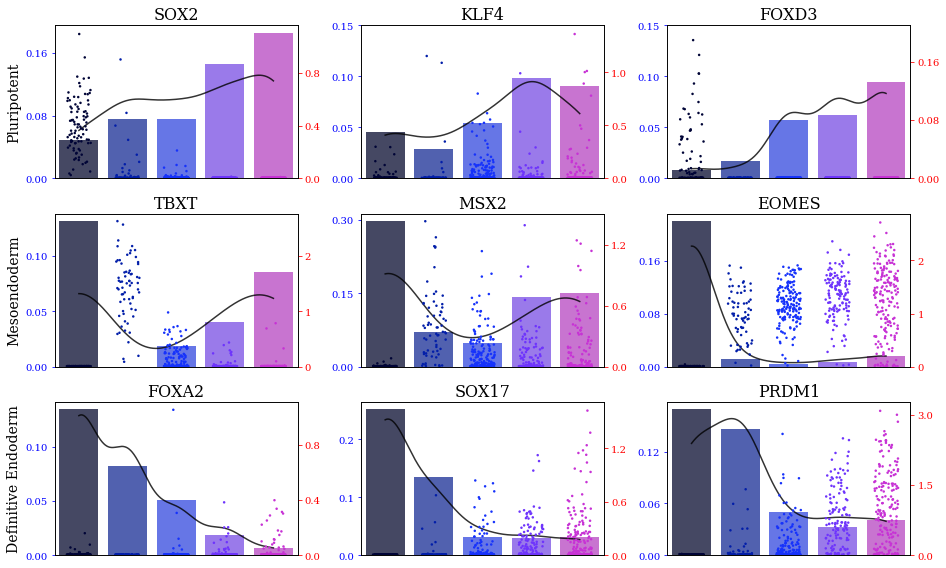

In [31]:
marker_genes = ['SOX2', 'KLF4', 'FOXD3', 'TBXT', 'MSX2', 'EOMES', 'FOXA2', 'SOX17', 'PRDM1']

marker_genes = np.array(marker_genes).reshape(3,3)
min_ylim = 0.1

fig, ax = plt.subplots(3,3, figsize=(13, 8))
for i in range(marker_genes.shape[0]):
    for j in range(marker_genes.shape[1]):
        marker = marker_genes[i,j]
        # Tbxt = T in the rna seq data
        if marker == "TBXT":
            marker_rna = "T"
        else:
            marker_rna = marker
        
        bin_range, freq = time_bins(marker, gsm_bin, gene_annot, cell_annot)
        x, y = kernel_est(bin_range, freq, 100)
        y = y*np.sum(freq)
        
        sns.barplot(bin_range[:-1], freq, alpha=.75, ax=ax[i,j])
        curve = ax[i,j].plot(x, y, 'k', alpha=.8)
        plt.setp(ax[i,j], xticks=[], title=marker)
        ax[i,j].tick_params('y', colors='b')
        # clause to set ylim to a certain value
        if max(freq) < 0.1:
            ax[i,j].set_ylim([0,.15])
        ax[i,j].yaxis.set_major_locator(plt.MaxNLocator(3))

        ax2 = ax[i,j].twinx()

        
        adata_tmp = adata[:,adata.var['gene'] == marker_rna]
        
        # remove 12 hour rna time point and assume day 1.5 RNA = day 2 k27me3
        adata_tmp = adata_tmp[adata_tmp.obs.time != '12h']
        xrna = np.array([np.round(int(i[0:2])/24) for i in adata_tmp.obs.time])
        yrna = np.array(adata_tmp.X).squeeze()
        
        # For plotting aesthetics (to see zeros), add .5% of max values
        yrna += (max(yrna) * .005)

        sns.stripplot(xrna, yrna, ax=ax2, alpha=1, s=2.5, jitter=.25)
        ax2.tick_params('y', colors='r')
        ax2.set_ylim(ymin=0)
        ax2.set_xticks([])
        ax2.yaxis.set_major_locator(plt.MaxNLocator(3))


fig.tight_layout()
timepoints = ['Pluripotent', 'Mesoendoderm', 'Definitive Endoderm']

for row, label in enumerate(timepoints):
    ax[row, 0].set_ylabel(label, fontsize = 14)

pdf_obj.savefig(bbox_inches='tight', transparent=True)
plt.show()

bulk_fragfiles/H1DE_agg.bed
bulk_fragfiles/H2DE_agg.bed
bulk_fragfiles/H3DE_agg.bed
bulk_fragfiles/H4DE_agg.bed
bulk_fragfiles/H5DE_agg.bed
bulk_fragfiles/K27me3_H1D1_0815.fragments.tsv
bulk_fragfiles/K27me3_H1D2_0815.fragments.tsv
bulk_fragfiles/K27me3_H1D3_0815.fragments.tsv
bulk_fragfiles/K27me3_H1D4_0815.fragments.tsv
bulk_fragfiles/K27me3_H1D5_0815.fragments.tsv


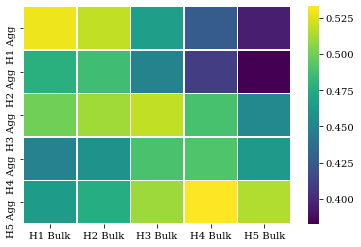

In [32]:
beds = sorted(glob.glob("bulk_fragfiles/K27me3_H1D?_0815.fragments.tsv.gz") + 
        glob.glob("bulk_fragfiles/H?DE_agg.bed.gz"))
sprse_matrices = []
for i in beds:
    print(i)
    sprse_matrices.append(getCoverage(i, genomeWindow))
    
scagg = sprse_matrices[:5]
scbulk = sprse_matrices[5:]
labels_sc = ['H1 Agg', 'H2 Agg', 'H3 Agg', 'H4 Agg', 'H5 Agg']
labels_bulk = ['H1 Bulk', 'H2 Bulk', 'H3 Bulk', 'H4 Bulk', 'H5 Bulk']
corr = np.zeros([len(labels_sc), len(labels_bulk)])
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        x = np.array(scagg[i].todense()).squeeze()
        y = np.array(scbulk[j].todense()).squeeze()
        corr[i, j] = stats.pearsonr(x, y)[0]
        
corr = pd.DataFrame(corr, index=labels_sc, columns=labels_bulk)
sns.heatmap(corr, cmap="viridis" ,linewidths=.5)

pdf_obj.savefig(bbox_inches='tight', transparent=True)


In [33]:
pdf_obj.close()